In [10]:
# Import packages
import sys
import os

import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt

import tqdm

import torch
import torch.optim as optim
from torch.autograd import Variable
import torch.nn.functional as F
import torch.nn as nn

from IPython.display import clear_output
from IPython import display

%matplotlib inline

# check and use GPU if available if not use CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

from torch.distributions import MultivariateNormal, Normal


In [11]:
class ContinuousActor(nn.Module):
    def __init__(
        self, 
        in_dim: int, 
        out_dim: int, 
    ):
        """Initialize."""
        super(ContinuousActor, self).__init__()

        self.hidden = nn.Linear(in_dim, 32)
        self.mu_layer = nn.Linear(32, out_dim)
        self.log_std_layer = nn.Linear(32, out_dim)

    def forward(self, state: torch.Tensor) -> torch.Tensor:
        """Forward method implementation."""
        x = F.relu(self.hidden(state))
        
        mu = torch.tanh(self.mu_layer(x))
        log_std = torch.tanh(self.log_std_layer(x))

        std = torch.exp(log_std)
        dist = Normal(mu, std)
        action = dist.sample()

        return action, dist

In [12]:
test_actor = ContinuousActor(3, 1)
action, dist = test_actor.forward(torch.tensor([1, 2, 3], dtype=torch.float32))

In [13]:
# CODE from another notebook
class NeuralNet(torch.nn.Module):
    def __init__(self, input_size, output_size, activation, layers=[32,32,16]):
        super().__init__()

        # Define layers with ReLU activation
        self.linear1 = torch.nn.Linear(input_size, layers[0])
        self.activation1 = torch.nn.ReLU()
        self.linear2 = torch.nn.Linear(layers[0], layers[1])
        self.activation2 = torch.nn.ReLU()
        self.linear3 = torch.nn.Linear(layers[1], layers[2])
        self.activation3 = torch.nn.ReLU()

        self.output_layer = torch.nn.Linear(layers[2], output_size)
        self.output_activation = activation

        # Initialization using Xavier normal (a popular technique for initializing weights in NNs)
        torch.nn.init.xavier_normal_(self.linear1.weight)
        torch.nn.init.xavier_normal_(self.linear2.weight)
        torch.nn.init.xavier_normal_(self.linear3.weight)
        torch.nn.init.xavier_normal_(self.output_layer.weight)

    def forward(self, inputs):
        # Forward pass through the layers
        x = self.activation1(self.linear1(inputs))
        x = self.activation2(self.linear2(x))
        x = self.activation3(self.linear3(x))
        x = self.output_activation(self.output_layer(x))
        return x


def generate_single_episode(env, policy_net):
    """
    Generates an episode by executing the current policy in the given env
    """
    states = []
    actions = []
    rewards = []
    log_probs = []
    max_t = 1000 # max horizon within one episode
    state, _ = env.reset()

    if isinstance(env.action_space, gym.spaces.Box):
        max_possible_action = float(env.action_space.high[0]) # Only works with a action space dim of 1
        min_possible_action = float(env.action_space.low[0]) # Only works with a action space dim of 1

    for t in range(max_t):
        #print(t)
        if isinstance(env.action_space, gym.spaces.Discrete):
            state = torch.from_numpy(state).float().unsqueeze(0)
        else:
            state = torch.from_numpy(state.flatten()).float()
            

        # if action space is discrete or continuous
        if isinstance(env.action_space, gym.spaces.Discrete):
            probs = policy_net.forward(Variable(state)) # get each action choice probability with the current policy network
            action = np.random.choice(env.action_space.n, p=np.squeeze(probs.detach().numpy())) # probablistic
        else:
            action, dist = policy_net.forward(state) # continuous
            # clip action to the action space
            action = torch.clamp(action, min=min_possible_action, max=max_possible_action)
            action = action.detach().numpy()
            probs = dist


        # compute the log_prob to use this in parameter update
        log_prob = None
        if isinstance(env.action_space, gym.spaces.Discrete):
            log_prob = torch.log(probs.squeeze(0)[action])
        else:
            log_prob = dist.log_prob(torch.tensor(action))
            # print(f"log_prob: {log_prob}")
            
        #print(log_prob)
        
        # append values
        states.append(state)
        actions.append(action)
        log_probs.append(log_prob)
        
        # take a selected action
        if isinstance(env.action_space, gym.spaces.Discrete):
            state, reward, terminated, truncated, _ = env.step(action)
            reward = (reward + 8.1) / 8.1
        else:
            state, reward, terminated, truncated, _ = env.step(action)
            reward = (reward + 8.1) / 8.1
        rewards.append(reward)

        if terminated | truncated:
            break
            
    return states, actions, rewards, log_probs


def evaluate_policy(env, policy_net):
    """
    Compute accumulative trajectory reward
    """
    states, actions, rewards, log_probs = generate_single_episode(env, policy_net)
    return np.sum(rewards)

In [14]:
def train_PPO(env, policy_net, policy_optimizer, value_net, value_optimizer, num_epochs, clip_val=0.2, gamma=0.99, entropy_coef=0.005, lamda=0.95):
    """
    Trains the policy network using PPO
    """

    # Generate an episode with the current policy network
    states, actions, rewards, log_probs = generate_single_episode(env, policy_net)
    T = len(states)
    
    # Create tensors depending on if it is discrete or continuous action space
    if isinstance(env.action_space, gym.spaces.Discrete):
        actions = torch.LongTensor(actions).to(device).view(-1,1)
    else:
        actions = torch.FloatTensor(actions).to(device).view(-1,1)


    states = np.vstack(states).astype(float)
    states = torch.FloatTensor(states).to(device)
    rewards = torch.FloatTensor(rewards).to(device).view(-1,1)
    log_probs = torch.FloatTensor(log_probs).to(device).view(-1,1)

    # Compute the generalized advantage estimate
    Gs = []
    G = 0
    for t in range(T-1,-1,-1):
        delta = (rewards[t] + gamma*value_net(states[t]) - value_net(states[t-1]))
        G = delta + gamma * G * lamda
        Gs.insert(0,G)
    Gs = torch.tensor(Gs).view(-1,1)
    # for t in range(T-1,-1,-1): # iterate in backward order to make the computation easier
    #     G = rewards[t] + gamma*G
    #     Gs.insert(0,G)
    # Gs = torch.tensor(Gs).view(-1,1)
    
    # Compute the advantage
    state_vals = value_net(states).to(device)
    with torch.no_grad():
        A_k = Gs - state_vals
        
    for _ in range(num_epochs):
        # Compute the value of the current states
        V = value_net(states).to(device)


        # Calculate probability of each action under the updated policy
        # compute the log_prob to use it in parameter update
        if isinstance(env.action_space, gym.spaces.Discrete):
            probs = policy_net.forward(states).to(device)
            curr_log_probs = torch.log(torch.gather(probs, 1, actions))
            # print(f"probs, discrete: {probs}")
        else:
            _, probs = policy_net.forward(states)
            curr_log_probs = probs.log_prob(actions)
            # print(f"probs, continuous: {probs}")

        # Calculate ratios r(theta)
        ratios = torch.exp(curr_log_probs - log_probs)
        
        # Calculate two surrogate loss terms in cliped loss
        surr1 = ratios * A_k
        surr2 = torch.clamp(ratios, 1-clip_val, 1+clip_val) * A_k
        
        # entropy 
        if not isinstance(env.action_space, gym.spaces.Discrete):
            entropy = probs.entropy().mean()
            actor_loss = (-torch.min(surr1, surr2).mean() - entropy_coef * entropy)
        else:
            # Calculate clipped loss value
            actor_loss = (-torch.min(surr1, surr2)).mean() # Need negative sign to run Gradient Ascent
        
        # Update policy network
        policy_optimizer.zero_grad()
        actor_loss.backward(retain_graph=True)
        policy_optimizer.step()
        
        # Update value net
        critic_loss = nn.MSELoss()(V, Gs)
        value_optimizer.zero_grad()
        critic_loss.backward()
        value_optimizer.step()
        
    return policy_net, value_net

  0%|          | 0/1 [00:00<?, ?it/s]

Episode: 0
The avg. test reward for episode 0 is 45.112595873860826 with std of 23.532076531160982.
Episode: 50
The avg. test reward for episode 50 is 40.05419186358958 with std of 29.178461552831482.
Episode: 100
The avg. test reward for episode 100 is 56.26755497161757 with std of 31.714815413422006.
Episode: 150
The avg. test reward for episode 150 is 56.327308841664674 with std of 30.962887905378082.
Episode: 200
The avg. test reward for episode 200 is 59.414950650392896 with std of 27.38226549537995.
Episode: 250
The avg. test reward for episode 250 is 60.28047008411734 with std of 34.354767988884944.
Episode: 300
The avg. test reward for episode 300 is 49.86295975915302 with std of 33.059883676212706.
Episode: 350
The avg. test reward for episode 350 is 64.87655351072502 with std of 26.95548332004414.
Episode: 400
The avg. test reward for episode 400 is 63.111824296119764 with std of 30.393482514323363.
Episode: 450
The avg. test reward for episode 450 is 74.7390050489766 with st

100%|██████████| 1/1 [18:56<00:00, 1136.41s/it]


Text(0.5, 1.0, 'PPO Learning Curve')

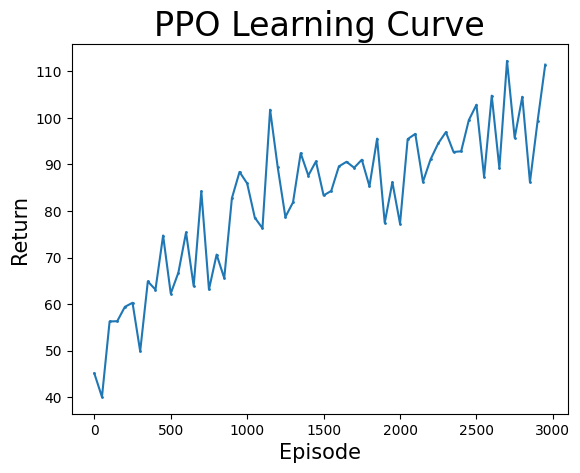

In [20]:
# Define parameter values
# env_name = 'CartPole-v0' # environment name
env_name = 'Pendulum-v1' # environment name

#env_name = 'LunarLander-v2' # environment name
# env_name = 'MountainCar-v0' # environment name
# env_name = 'Acrobot-v1' # environment name


num_train_ite = 3000 # number of training iterations
num_seeds = 1 # fit model with 3 different seeds and plot average performance of 3 seeds
num_epochs = 10 # how many times we iterate the entire training dataset passing through the training
eval_freq = 50 # run evaluation of policy at each eval_freq trials
eval_epi_index = num_train_ite//eval_freq # use to create x label for plot
returns = np.zeros((num_seeds, eval_epi_index))
gamma = 0.9 # discount factor
clip_val = 0.2 # hyperparameter epsilon in clip objective
entropy_coef = 0.005 # hyperparameter entropy coefficient 

# Create the environment.
env = gym.make(env_name)

#detect if the environment is discrete or continuous
if isinstance(env.action_space, gym.spaces.Discrete):
    nA = env.action_space.n
else:
    nA = env.action_space.shape[0]

# detect if the environment state is discrete or continuous
if isinstance(env.observation_space, gym.spaces.Discrete):
    nS = env.observation_space.n
else:
    nS = env.observation_space.shape[0]

policy_lr = 1e-4 # policy network's learning rate 
baseline_lr = 5e-4 # value network's learning rate
 
for i in tqdm.tqdm(range(num_seeds)):
    reward_means = []

    # Define policy and value networks
    if isinstance(env.action_space, gym.spaces.Discrete):
        policy_net = NeuralNet(nS, nA, torch.nn.Softmax()) # Normally this one works with CartPole-v0
    else:
        #policy_net = NeuralNet(nS, nA, torch.nn.Identity())
        policy_net = ContinuousActor(nS, nA)
    policy_net_optimizer = optim.Adam(policy_net.parameters(), lr=policy_lr)
    value_net = NeuralNet(nS, 1, torch.nn.ReLU())
    value_net_optimizer = optim.Adam(value_net.parameters(), lr=baseline_lr)
    
    for m in range(num_train_ite):
        # Train networks with PPO
        policy_net, value_net = train_PPO(env, policy_net, policy_net_optimizer, value_net, value_net_optimizer, num_epochs, clip_val=clip_val, gamma=gamma, entropy_coef=entropy_coef)
        if m % eval_freq == 0:
            print("Episode: {}".format(m))
            G = np.zeros(20)
            for k in range(20):
                g = evaluate_policy(env, policy_net)
                G[k] = g

            reward_mean = G.mean()
            reward_sd = G.std()
            print("The avg. test reward for episode {0} is {1} with std of {2}.".format(m, reward_mean, reward_sd))
            reward_means.append(reward_mean)
    returns[i] = np.array(reward_means)

# save the policy network
torch.save(policy_net.state_dict(), f"policy_net_{env_name}.pt")


# Plot the performance over iterations
x = np.arange(eval_epi_index)*eval_freq
avg_returns = np.mean(returns, axis=0)
max_returns = np.max(returns, axis=0)
min_returns = np.min(returns, axis=0)

plt.fill_between(x, min_returns, max_returns, alpha=0.1)
plt.plot(x, avg_returns, '-o', markersize=1)

plt.xlabel('Episode', fontsize = 15)
plt.ylabel('Return', fontsize = 15)

plt.title("PPO Learning Curve", fontsize = 24)

In [16]:
import time
#create an environment to test and visualize the policy
# env_name = 'CartPole-v0' # environment name
env_name = 'Pendulum-v1' # environment name
# env_name = 'MountainCar-v0' # environment name
# env_name = 'Acrobot-v1' # environment name
env = gym.make(env_name, render_mode='human')

if isinstance(env.action_space, gym.spaces.Discrete):
    nS = env.observation_space.shape[0]
    nA = env.action_space.n
    policy_net = NeuralNet(nS, nA, torch.nn.Softmax())
else:
    nS = env.observation_space.shape[0]
    nA = env.action_space.shape[0]
    policy_net = ContinuousActor(nS, nA)

# load the policy network
policy_net.load_state_dict(torch.load(f"policy_net_{env_name}.pt"))
# policy_net.eval()

episodes = 1
state = env.reset()[0]
rewards = []
for i in range(episodes):
    while True:
        action, _ = policy_net.forward(torch.tensor(state, dtype=torch.float32))
        # clip action to the action space
        action = torch.clamp(action, min=-2, max=2)
        
        # take a selected action
        action = action.detach().numpy()
        state, reward, done, truncated, _ = env.step(action)
        if done or truncated:
            break
        state = torch.from_numpy(state.flatten()).float()
        rewards.append(reward)
    print(f"Episode {i}: {np.sum(rewards)}")
    env.reset()
env.close()
    
    
# for i in range(episodes):
#     try:
#         reward = evaluate_policy(env, policy_net)
#     except Exception as e:
#         # print error and traceback
#         print(e)
        
#         env.close()

#     print(f"Episode {i}: {reward}")
# env.close()

C:\Users\lisas\AppData\Local\Temp\ipykernel_23860\848387439.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  action, _ = policy_net.forward(torch.tensor(state, dtype=torch.float32))


Episode 0: -256.1678833791283


In [23]:
env_name = 'Pendulum-v1' # environment name
env = gym.make(env_name, render_mode='human')
action = 2
state = env.reset()[0]
for i in range(200):
    state, reward, done, truncated, _ = env.step([action])
    if done or truncated:
        break
env.close()